In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as sp
from PIL import Image
from skimage.transform import (radon, iradon)
from scipy.spatial.transform import Rotation as R
from os.path import isdir
import os
import sys
sys.path.append("TV-DART/")

import imageio.v2 as imageio

import time
import utils
import astra


import algotom.io.loadersaver as losa
import algotom.io.converter as cvr
import algotom.prep.correction as corr
import algotom.prep.calculation as calc
import algotom.prep.removal as remo
import algotom.prep.filtering as filt
import algotom.rec.reconstruction as rec

%load_ext autoreload
%autoreload 2

In [2]:
def extract_square(image, corner, side_length):
    return image[corner[0]:corner[0]+side_length, corner[1]:corner[1]+side_length]

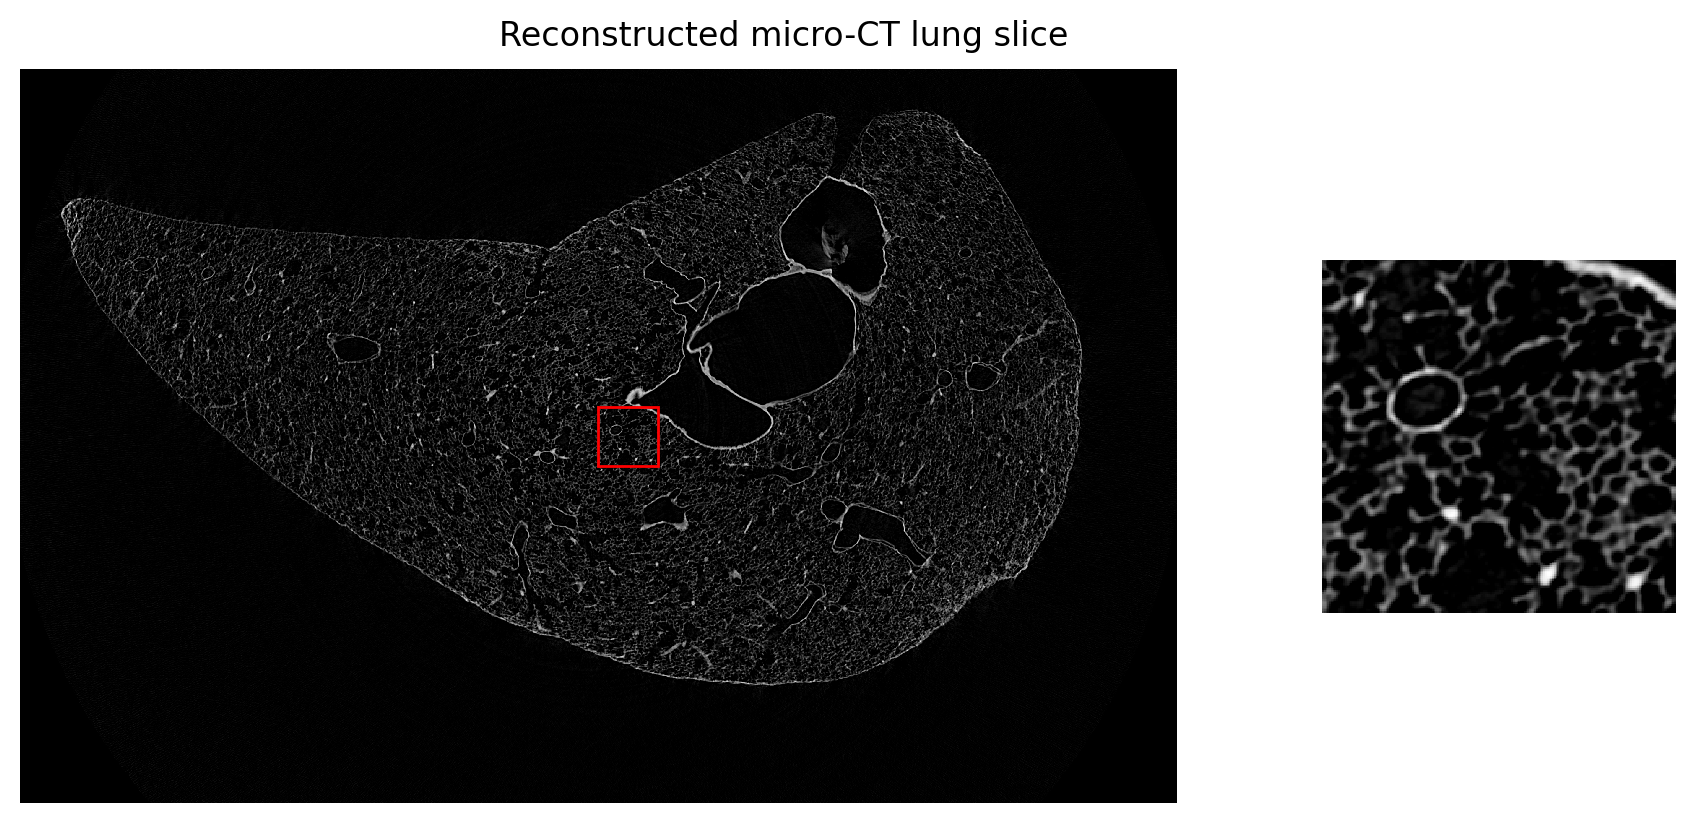

In [3]:
# Importing an already reconstructed slice
img = Image.open(r"1471_P2_M2.bmp")
# img = losa.load_image(r"1471_P2_M2.bmp")
slice = np.array(img)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4), dpi=200, gridspec_kw={'width_ratios': [4, 1]}, layout='constrained')
ax1.imshow(slice, cmap=plt.cm.Greys_r, interpolation='nearest')
ax1.axis('off')

corner = [slice.shape[0]//2-100, slice.shape[1]//2]
vertex = [slice.shape[1]//2, slice.shape[0]//2-100]
side_length = 200

rect = patches.Rectangle(vertex, side_length, side_length, linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax2.imshow(extract_square(slice, corner, side_length), cmap=plt.cm.Greys_r, interpolation='nearest')
ax2.axis('off')
fig.suptitle("Reconstructed micro-CT lung slice")
plt.show()

In [4]:
# Zero-padding original image
print(np.max(slice))
print(np.min(slice))

height, width = slice.shape
print(f"before padding - height = {height}, width = {width}")

diff = width - height
pad_width = diff//2
slice = np.pad(slice, ((pad_width, pad_width), (0,0)), mode='constant', constant_values=0)
slice = np.roll(slice, 100, axis=(0,1))
nheight, nwidth = slice.shape
print(f"after padding  - height = {nheight}, width = {nwidth}")

226
0
before padding - height = 2484, width = 3916
after padding  - height = 3916, width = 3916


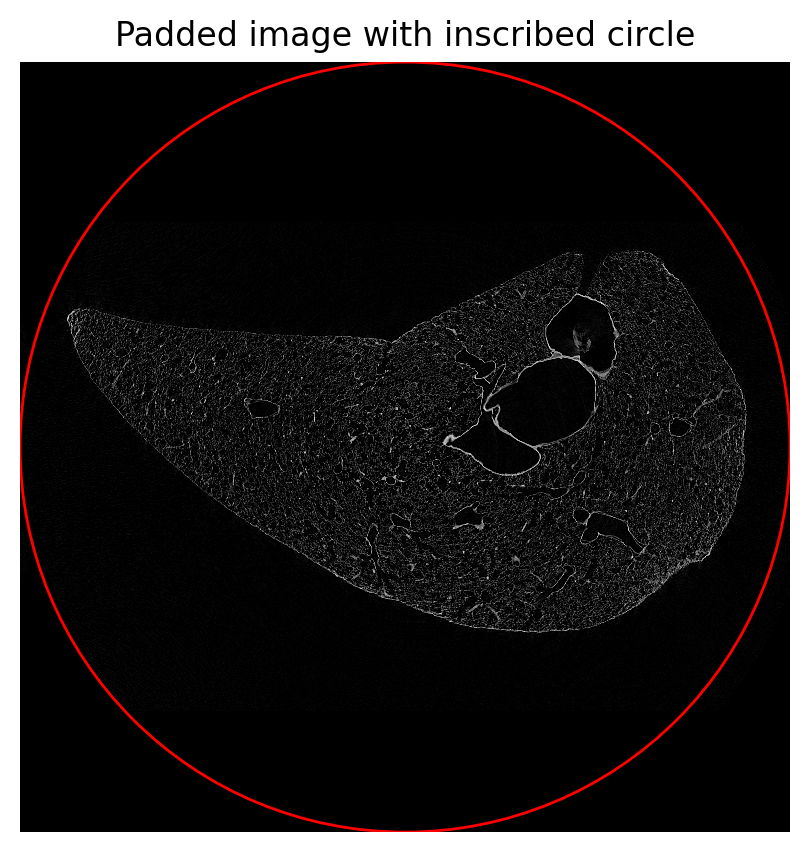

In [5]:
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
ax.imshow(slice, cmap=plt.cm.Greys_r, interpolation='nearest')
circle = patches.Circle((nheight//2, nwidth//2), slice.shape[0]//2, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(circle)
ax.axis('off')
ax.set_title("Padded image with inscribed circle")
plt.show()

In [65]:
sino_slice = radon(slice, theta=np.arange(0.0, 180.0, step=0.2))

c:\Users\bherr\miniconda3\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


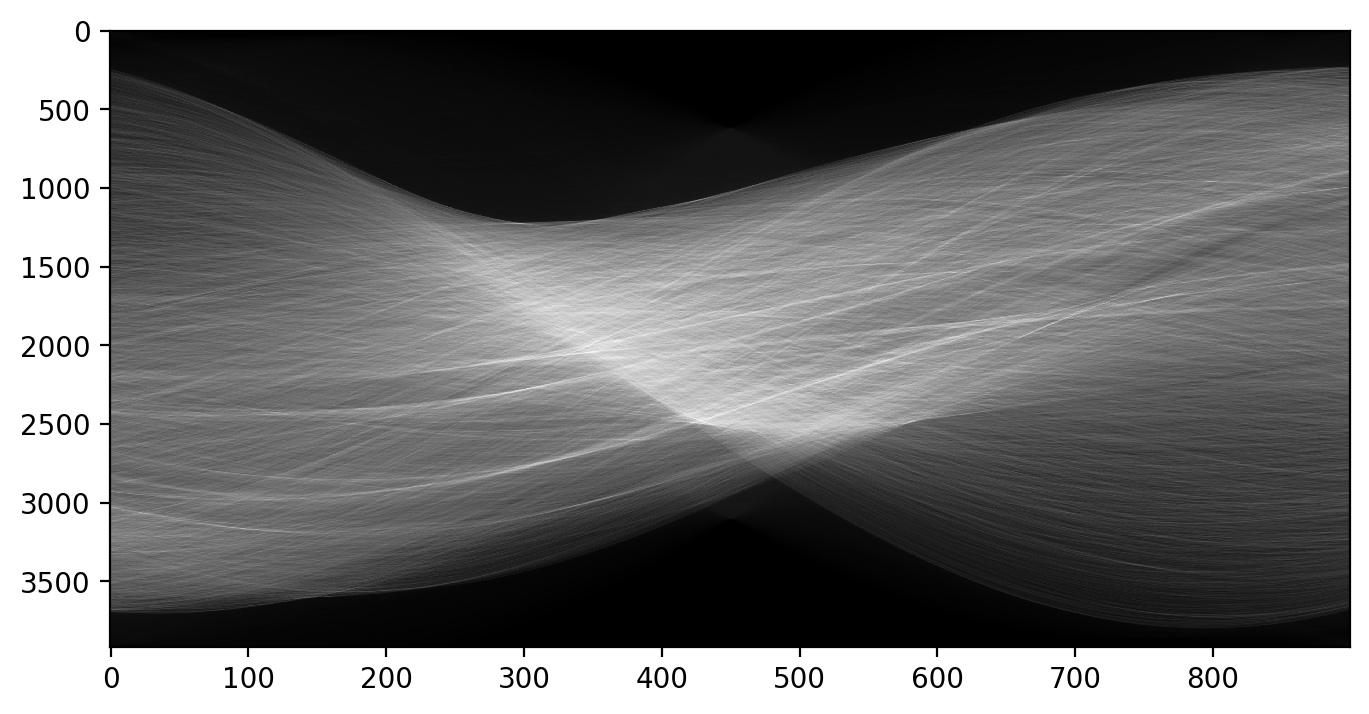

In [67]:
fig, ax = plt.subplots(figsize=(8,4), dpi=200)
ax.imshow(sino_slice, cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
plt.show()

In [95]:
np.save('sino_from_reconstructed_slice.npy', sino_slice)

In [7]:
sino_slice = np.load('sino_from_reconstructed_slice.npy')

In [13]:
slice.shape

(3916, 3916)

Reconstruction completed in 0.3123354911804199 seconds.


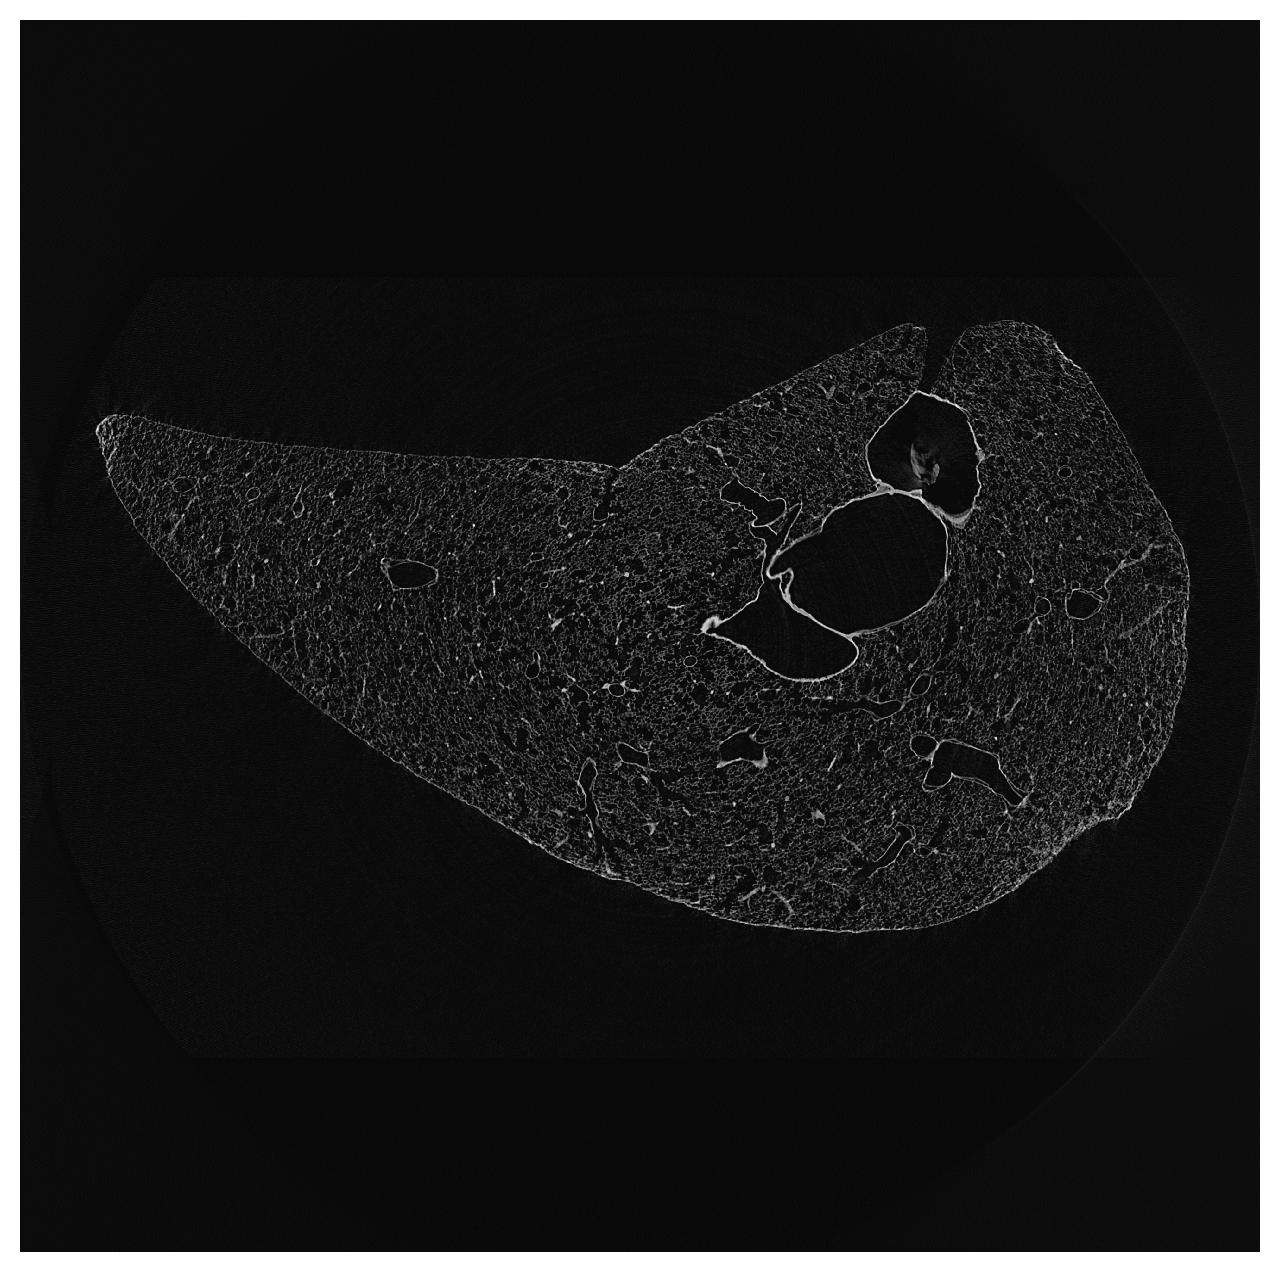

In [20]:
# height = 3916, width = 3916

detector_cols = nwidth

proj_geom = astra.create_proj_geom('parallel', 1.0, detector_cols, np.deg2rad(np.arange(0.0, 180.0, step=0.1)))
vol_geom = astra.create_vol_geom(detector_cols, detector_cols)

proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
sinogram_id, sinogram = astra.create_sino(slice, proj_id)

# sinogram = remo.remove_zinger(sinogram, 0.08)
sinogram = remo.remove_stripe_based_normalization(sinogram, 0.1)
# sinogram = filt.fresnel_filter(sinogram, 100, apply_log=False)

sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram)
reconstruction_id = astra.data2d.create('-vol', vol_geom)

# Instance and run reconstruction algorithm in GPU
cfg = astra.astra_dict('FBP_CUDA')
cfg['ReconstructionDataId'] = reconstruction_id
cfg['ProjectionDataId'] = sinogram_id
algorithm_id = astra.algorithm.create(cfg)
t0 = time.time()
astra.algorithm.run(algorithm_id)
reconstruction = astra.data2d.get(reconstruction_id)
print(f"Reconstruction completed in {time.time() - t0} seconds.")

fig, ax = plt.subplots(figsize=(8,8), dpi=200)
ax.imshow(reconstruction, cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.axis('off')
plt.show()

In [80]:
reconstructed_slice = iradon(sino_slice, theta=np.arange(0.0, 180.0, step=0.2), filter_name='ramp')

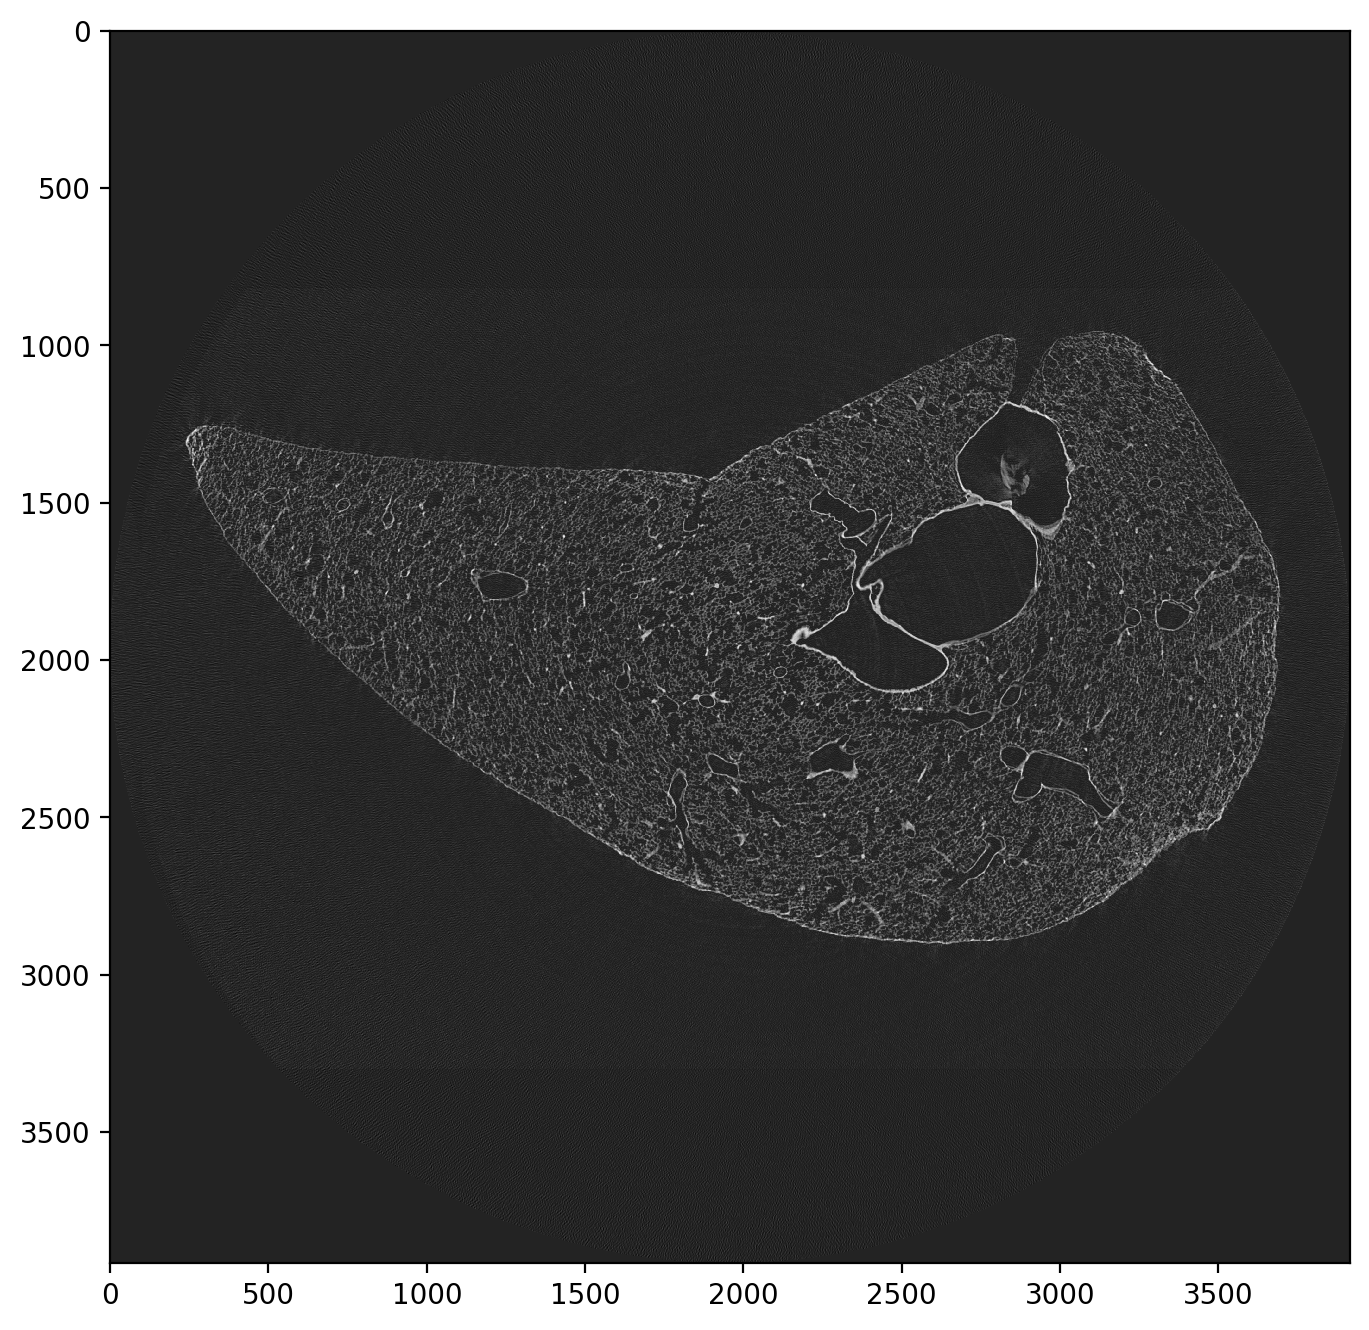

In [81]:
fig, ax = plt.subplots(figsize=(8,8), dpi=200)
ax.imshow(reconstructed_slice, cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.axis('off')
plt.show()

In [ ]:
 corr.upsample_sinogram

In [24]:
# Interpolation 

corner = [slice.shape[0]//2-200, slice.shape[1]//2]
side_length = 400

sq = extract_square(slice, corner, side_length)

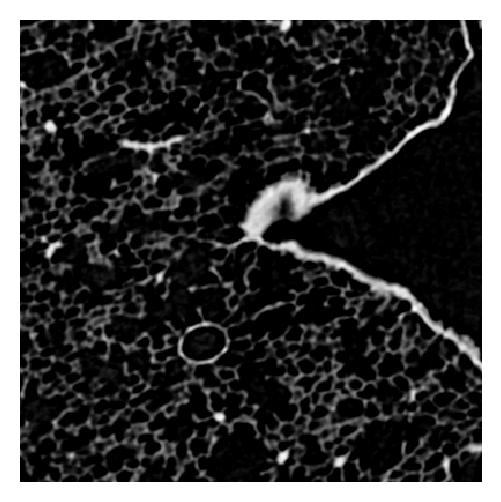

In [26]:
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.imshow(sq, cmap=plt.cm.Greys_r, interpolation='nearest')
ax.axis('off')
plt.show()

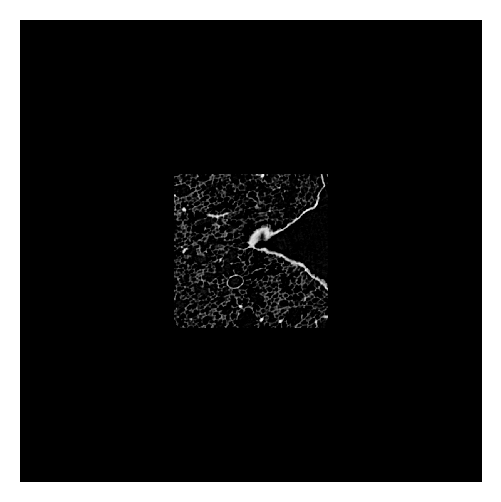

In [27]:
padded_sq = np.pad(sq, pad_width = sq.shape[0], mode='constant', constant_values=0)
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.imshow(padded_sq, cmap=plt.cm.Greys_r, interpolation='nearest')
ax.axis('off')
plt.show()

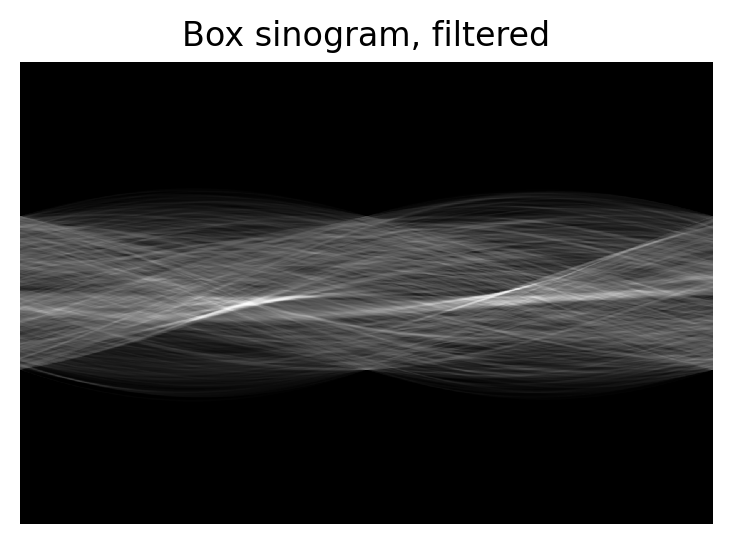

Reconstruction completed in 0.0861 seconds.


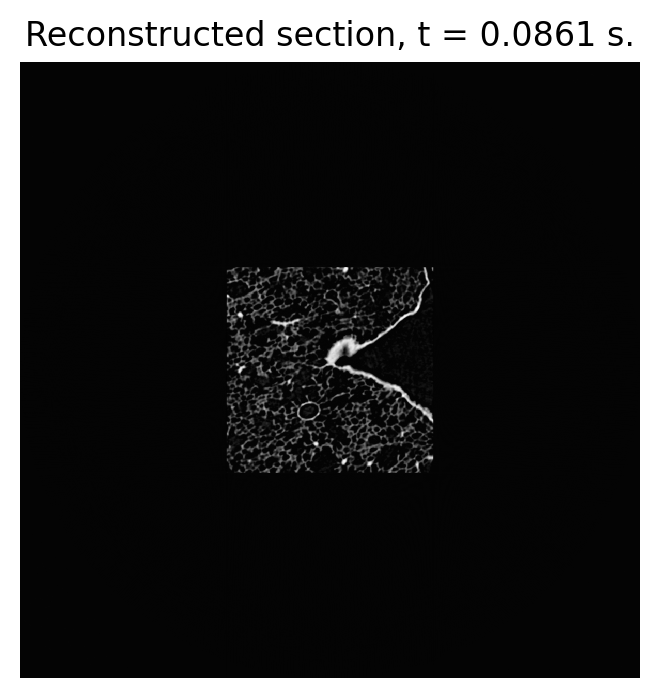

In [55]:
detector_cols = padded_sq.shape[0]

proj_geom = astra.create_proj_geom('parallel', 1.0, detector_cols, np.deg2rad(np.arange(0.0, 180.0, step=0.1)))
vol_geom = astra.create_vol_geom(detector_cols, detector_cols)

proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
sinogram_id, sinogram = astra.create_sino(padded_sq, proj_id)

# sinogram = remo.remove_zinger(sinogram, 0.08)
sinogram = remo.remove_stripe_based_normalization(sinogram, 0.1)
sino_shape = sinogram.shape
# sinogram = filt.fresnel_filter(sinogram, 100, apply_log=False)

fig, ax = plt.subplots(figsize=(6,3), dpi=200)
ax.imshow(sinogram.T, cmap=plt.cm.Greys_r, interpolation='nearest')
ax.axis('off')
ax.set_title("Box sinogram, filtered")
plt.show()

sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram)
reconstruction_id = astra.data2d.create('-vol', vol_geom)

# Instance and run reconstruction algorithm in GPU
cfg = astra.astra_dict('FBP_CUDA')
cfg['ReconstructionDataId'] = reconstruction_id
cfg['ProjectionDataId'] = sinogram_id
algorithm_id = astra.algorithm.create(cfg)
t0 = time.time()
astra.algorithm.run(algorithm_id)
reconstruction = astra.data2d.get(reconstruction_id)
t1 = time.time()
print(f"Reconstruction completed in {round(t1 - t0, 4)} seconds.")

fig, ax = plt.subplots(figsize=(4,4), dpi=200)
ax.imshow(reconstruction, cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.axis('off')
ax.set_title(f"Reconstructed section, t = {round(t1 - t0, 4)} s.")
plt.show()

(2160000,)


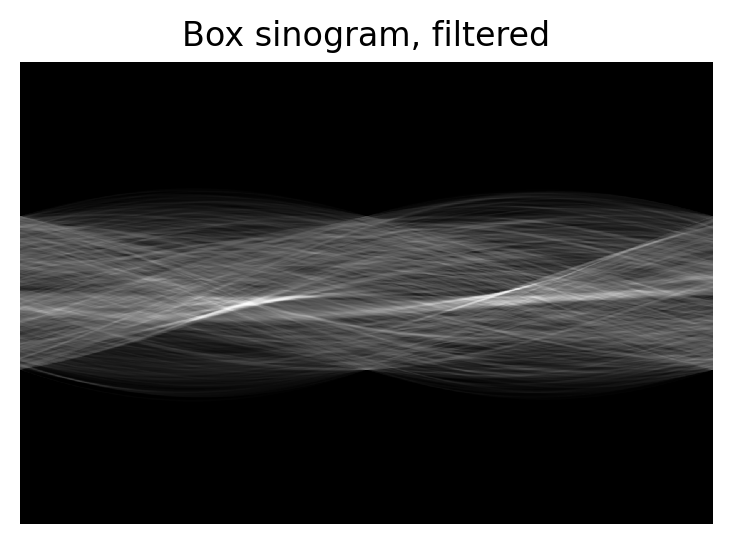

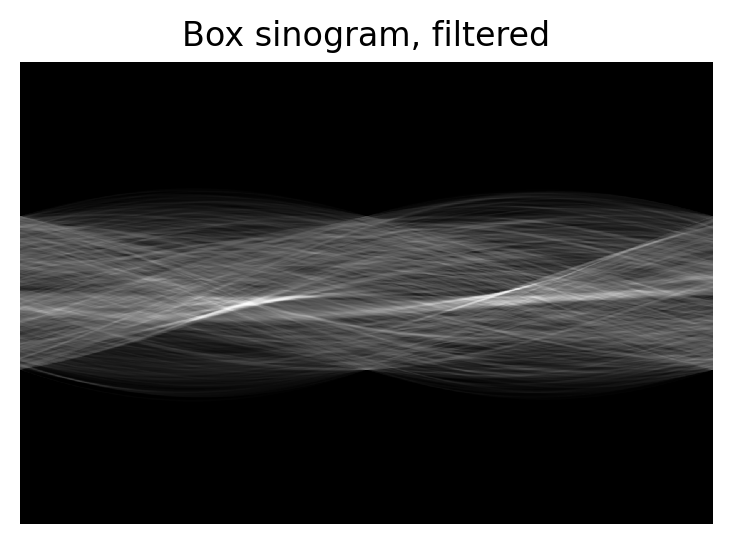

In [57]:
sinogram_flattened = sinogram.flatten(order='F')
print(sinogram_flattened.shape)
sinogram_unflattened = sinogram.reshape(sino_shape, order='F')
fig, ax = plt.subplots(figsize=(6,3), dpi=200)
ax.imshow(sinogram.T, cmap=plt.cm.Greys_r, interpolation='nearest')
ax.axis('off')
ax.set_title("Box sinogram, filtered")
plt.show()
fig, ax = plt.subplots(figsize=(6,3), dpi=200)
ax.imshow(sinogram_unflattened.T, cmap=plt.cm.Greys_r, interpolation='nearest')
ax.axis('off')
ax.set_title("Box sinogram, filtered")
plt.show()

In [61]:
import TVRDART

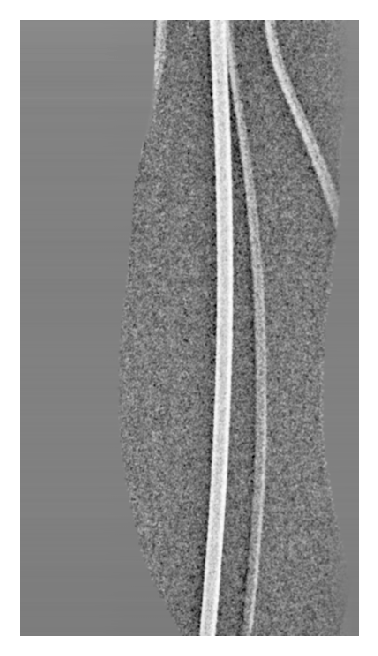

In [62]:
nanotubedata = np.load('TV-DART/nanotube2d.npy')
fig, ax = plt.subplots(figsize=(4,4), dpi=200)
ax.imshow(nanotubedata, cmap=plt.cm.Greys_r, interpolation='nearest')
ax.axis('off')
# ax.set_title(f"Reconstructed section, t = {round(t1 - t0, 4)} s.")
plt.show()

Initial reconstruction...
reconstruction i=0, j=0
Reconstruction with estimated parameters...
siz = (1200, 1200)
Initial reconstruction...
reconstruction i=0, j=1
Reconstruction with estimated parameters...
siz = (1200, 1200)
Initial reconstruction...
reconstruction i=1, j=0
Reconstruction with estimated parameters...
siz = (1200, 1200)
Initial reconstruction...
reconstruction i=1, j=1
Reconstruction with estimated parameters...
siz = (1200, 1200)


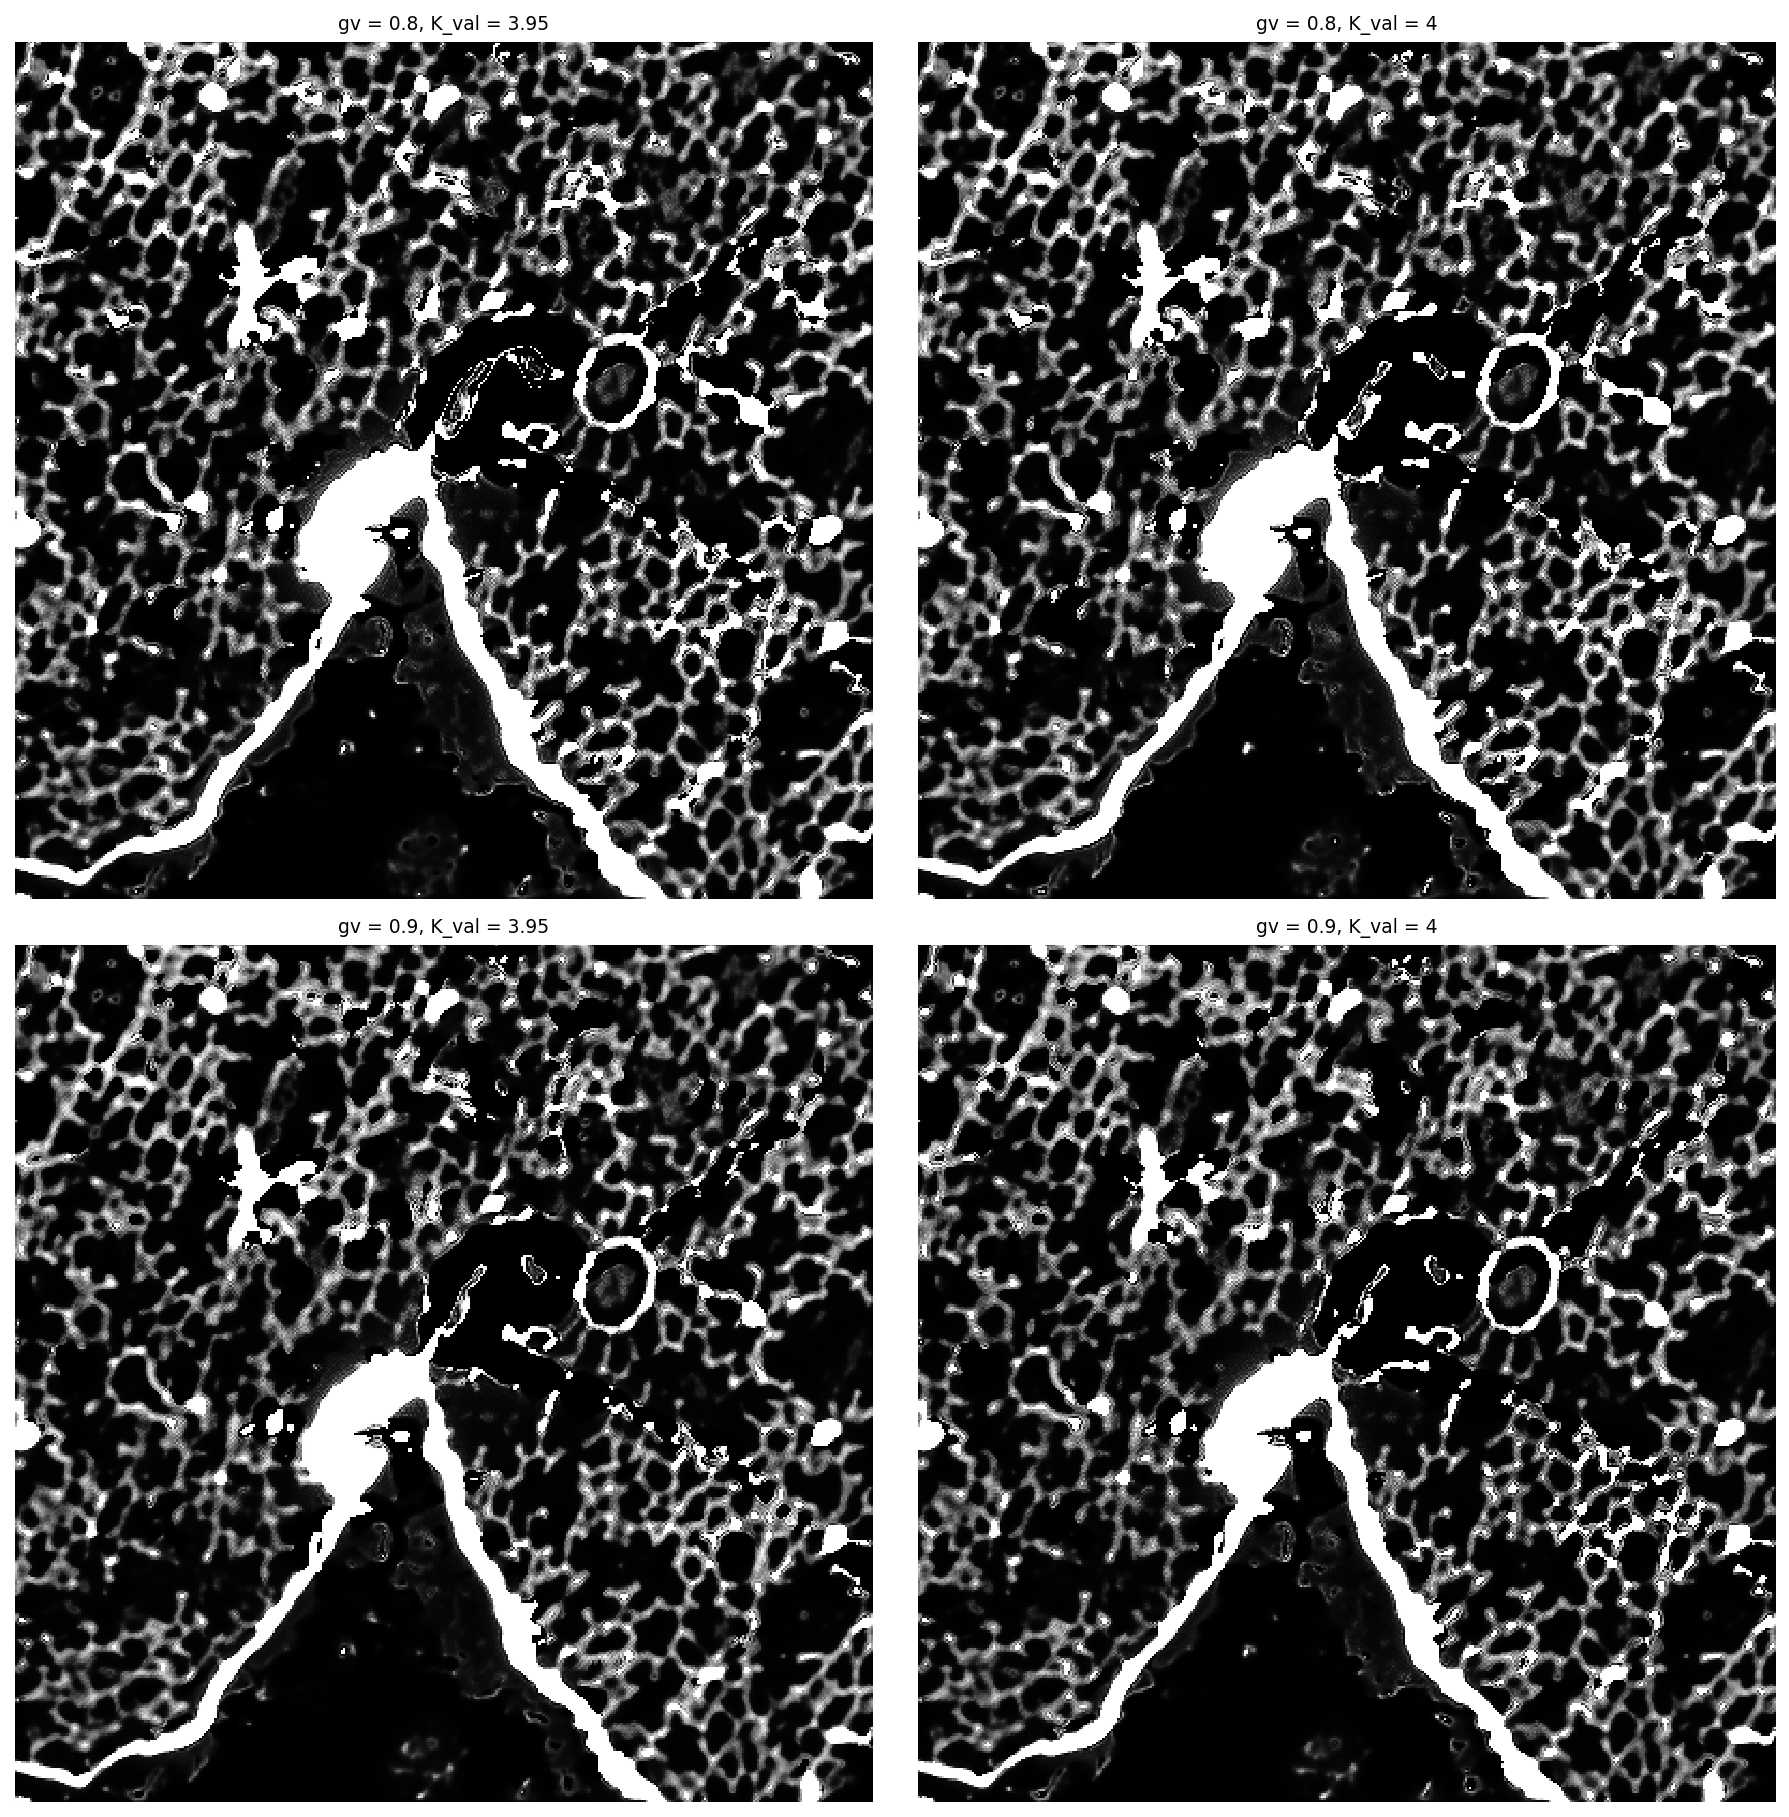

In [147]:
# gvs = [0.5]
# Ks = [3]

gvs = np.linspace(0.8, 0.9, 3, endpoint=True)
# Ks = np.linspace(1,3, 3, endpoint=True)
Ks = [3.95,4]

results = []

fig, axs = plt.subplots(len(gvs), len(Ks), figsize=(12,12), dpi=150, layout='constrained')

for i,gv_val in enumerate(gvs):

    gv_val_results = []

    for j,K_val in enumerate(Ks):
         
                
        W = astra.OpTomo(proj_id)

        [Nan,Ndetx] = sinogram.shape

        # Configuration of TVR-DART parameters
        Ngv = 2 # number of material composition in the specimen (including vacuum)
        K = 4*np.ones(Ngv-1) # sharpness of soft segmentation function
        lamb = 10 # weight of TV
        Niter = 50 # number of iterations

        # Initial reconstruction and normalization
        print('Initial reconstruction...')
        import SIRT
        recsirt = SIRT.recon(sinogram, 50, proj_geom, vol_geom, 'cuda')
        sf = np.max(recsirt)
        data = sinogram/sf
        p = data.reshape(Nan*Ndetx)
        recsirt = recsirt/sf
        # fig, ax = plt.subplots()
        # ax.imshow(recsirt, cmap=plt.cm.Greys_r, interpolation='nearest')
        # plt.show()
        # print(f"recsirt = {recsirt}")
            
        # Automatic parameter estimation
        # print('Parameter estimation...')




        print(f"reconstruction i={i}, j={j}")
        # gv = np.linspace(0, 1, Ngv,True)

        gv = np.array([0., gv_val])
        K = np.array([K_val])

        # param0 = TVRDART.gv2param(gv,K)
        # print(f"param0 = {gv}")
        # Segrec,param_esti = TVRDART.joint(W, p, recsirt, param0 ,lamb)
        # [gv,K] = TVRDART.param2gv(param_esti)

        param_esti = TVRDART.gv2param(gv, K)

        # Reconstruction with estimated parameters
        print('Reconstruction with estimated parameters...')
        Segrec,rec = TVRDART.recon(W,p, recsirt, param_esti, lamb, Niter)
        gv = gv*sf
        recsirt = recsirt*sf
        Segrec = Segrec*sf;

        amin = np.min(Segrec)
        amax = np.max(Segrec)
        if len(gvs) == 1 and len(Ks) == 1: 
            axs.imshow(Segrec[400:800,400:800], cmap=plt.cm.Greys_r, interpolation='nearest', vmin=amin, vmax=amax)
            axs.axis('off')
            axs.set_title(f"gv = {gv_val}, K_val = {K_val}", size=9)   
        else:
            axs[i,j].imshow(Segrec[400:800,400:800], cmap=plt.cm.Greys_r, interpolation='nearest', vmin=amin, vmax=amax)
            axs[i,j].axis('off')
            axs[i,j].set_title(f"gv = {gv_val}, K_val = {K_val}", size=9)

        gv_val_results.append(Segrec)

    results.append(gv_val_results)

plt.show()

In [109]:
results

[]

3.2504052849295793e-26
73.33911743164063


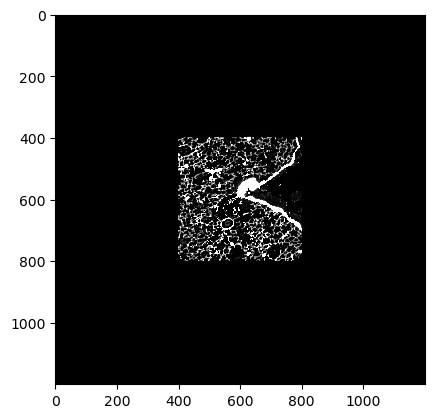

In [149]:
i = 0
j = 0
amin = np.min(results[i][j])
amax = np.max(results[i][j])
print(amin)
print(amax)

plt.imshow(results[i][j].T, cmap=plt.cm.Greys_r, interpolation='nearest', vmin=amin, vmax=amax)

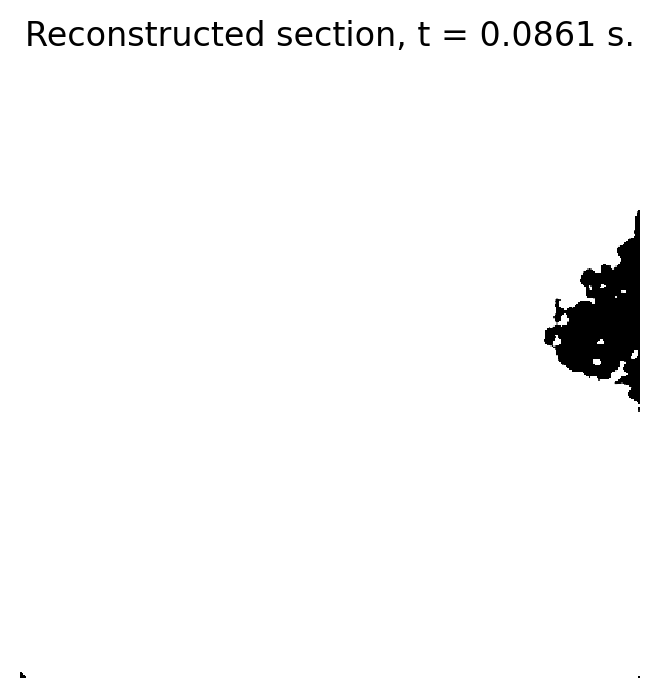

In [70]:
fig, ax = plt.subplots(figsize=(4,4), dpi=200)
ax.imshow(Segrec[400:800,400:800], cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.axis('off')
ax.set_title(f"Reconstructed section, t = {round(t1 - t0, 4)} s.")
plt.show()

In [85]:
import tomopy

In [138]:
angles = np.deg2rad(np.arange(0.0, 180.0, step=0.1))
print(f"sinogram shape = {np.stack((sinogram, sinogram)).shape}")
recon = tomopy.recon(np.stack((sinogram, sinogram)).reshape(1800,2,1200), angles, algorithm='tv')

sinogram shape = (2, 1800, 1200)


KeyboardInterrupt: 

In [133]:
recon.shape

(2, 1200, 1200)

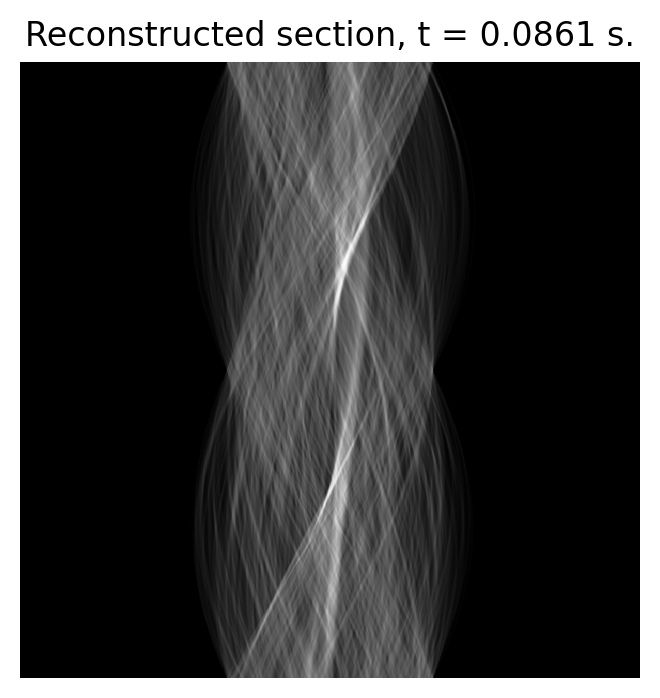

In [137]:
fig, ax = plt.subplots(figsize=(4,4), dpi=200)
ax.imshow(sinogram, cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.axis('off')
ax.set_title(f"Reconstructed section, t = {round(t1 - t0, 4)} s.")
plt.show()